In [1]:
import kaleido
import pandas as pd
import numpy as np
import plotly.graph_objects as go
######## Search space #########
import sys
sys.path.append("../")
from search_space.RegNet import RegNet
from search_space.utils import create_widths_plot, scatter_results
# Initialize an empty list to store dictionaries
def results_to_df(path, name):
    data = []
    # Open the text file
    with open(path, 'r') as file:
        lines = file.readlines()
        # Initialize an empty dictionary to store data for each block
        block_data = {}
        for line in lines:
            # If the line contains dashes, it indicates the end of a block
            if '-------------------------' in line:
                # If block_data is not empty, add it to the list of data dictionaries
                if block_data:
                    data.append(block_data)
                    # Reset block_data for the next block
                    block_data = {}
            elif 'best_acc' in line:
                continue
            else:
                # Split the line by ':'
                #print(line)
                key, value = line.strip().split(': ')
                # Store the key-value pair in the block_data dictionary
                block_data[key] = value

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)

    # Convert columns to appropriate data types if needed
    df['epoch'] = df['epoch'].astype(int)
    df['lr'] = df['lr'].astype(float)
    df['train_acc'] = df['train_acc'].astype(float)
    df['train_loss'] = df['train_loss'].astype(float)
    df['test_acc'] = df['test_acc'].astype(float)
    df['test_acc_top5'] = df['test_acc_top5'].astype(float)
    df['test_loss'] = df['test_loss'].astype(float)
    df['epoch_time'] = df['epoch_time'].astype(float)
    df=df.assign(name=name)
    
    return df

/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import os

metadata_dict={}
metadata_dict["Caitie"]={'num_classes': 4,
                         'input_shape': [49260, 3, 64, 64],
                         'codename': 'Caitie',
                         'benchmark': 47.008,
                         }
metadata_dict["Adaline"]={'num_classes': 20,
                         'input_shape': [50000, 3, 28, 28],
                         'codename': 'Adaline',
                         'benchmark': 89.85}
metadata_dict["Chester"]={'input_shape': [49998, 12, 8, 8],
                         'codename': 'Chester',
                         'benchmark': 57.826,
                         'num_classes': 3}
metadata_dict["Gutenberg"]={'input_shape': [45000, 1, 27, 18],
                         'codename': 'Gutenberg',
                         'benchmark': 40.98,
                         'num_classes': 6}
metadata_dict["LaMelo"]={'num_classes': 10,
                         'codename': 'LaMelo',
                         'input_shape': [50000, 1, 24, 24],
                         'benchmark': 85.2}
metadata_dict["Mateo"]={'num_classes': 10,
                         'input_shape': [50000, 3, 28, 28],
                         'codename': 'Mateo',
                         'benchmark': 90.87}
metadata_dict["Sadie"]={'input_shape': [50000, 3, 64, 64],
                         'codename': 'Sadie',
                         'benchmark': 80.33,
                         'num_classes': 10}
def get_predictor_data_from_folder(base_folder,studies):

    
    train_data=[]
    for study_name in studies: 
        

        metadata=metadata_dict[study_name]
        rg=RegNet(metadata,
                        W0=[16, 120, 8],
                        WA=[16, 64, 8],
                        WM=[2.05,2.9,0.05],
                        D=[8,22,1], 
                        G=[8,8,8], 
                        base_config=f"../configs/search_space/config.yaml")
        data=[]
        study_folder=f"{base_folder}/{study_name}"
        subjects= os.listdir(study_folder)

        subjects=[subject for subject in subjects if os.path.isdir(f"{study_folder}/{subject}")]
        print(subjects)
        for name in subjects:
            try:
                test_acc=results_to_df(f"{study_folder}/{name}/worklog.txt", f"{name}")[["epoch","test_acc","name"]]
                #test_acc=test_acc.rename(columns={"test_acc":"acc","test_loss":"test_acc"})
                #print(test_acc.columns)
                if len(test_acc)>49:
                    test_acc_piv = test_acc[["epoch","test_acc","name"]].pivot(index='name', columns='epoch', values='test_acc').add_prefix("epoch_").reset_index()
                    test_acc_piv["best_acc"]=test_acc["test_acc"].max()
                    
                    model, info=rg.load_model(config_file=f"{study_folder}/{name}/config.yaml")
                    test_acc_piv["gen"]=1
                    test_acc_piv["num_stages"]=info["num_stages"]
                    test_acc_piv["params"]=info["params"]
                    test_acc_piv["WA"]=info["WA"]
                    test_acc_piv["W0"]=info["W0"]
                    test_acc_piv["WM"]=info["WM"]
                    test_acc_piv["DEPTH"]=info["DEPTH"]
                    test_acc_piv["num_classes"]=metadata["num_classes"]
                    test_acc_piv["num_channels"]=metadata["input_shape"][1]
                    test_acc_piv["benchmark"]=metadata["benchmark"]
                    
                    #print(info)
                    data.append(test_acc_piv)
            except:
                    pass

        data=pd.concat(data)
        train_data.append(data)
    train_data=pd.concat(train_data)
    return train_data
    

In [3]:
import json


def get_predictor_data(tests_folder,studies):
    train_data=[]
    for study_name in studies: 
        #study_name="tests_LaMelo_13_06_2024_02_11"
        file_path=f"{tests_folder}/{study_name}/{study_name}.evonas"
        with open(file_path, 'r') as file:
            results = json.load(file)

        individuals_df=pd.read_json(results["results"]).sort_values("name")[["name","generation"]]
        data_models=pd.read_json(results["results"])[["name","num_stages","params","WA","W0","WM","DEPTH", "best_acc"]]
        data_models["num_classes"]=results["metadata"]["num_classes"]
        data_models["num_channels"]=results["metadata"]["input_shape"][1]
        data_models["benchmark"]=results["metadata"]["benchmark"]
        print(study_name)
        print(results["metadata"])

        data=[]
        for index, row in individuals_df.iterrows():
            name=row["name"]
            generation=row["generation"]
            try:
                test_acc=results_to_df(f"{tests_folder}/{study_name}/Generation_{generation}/{name}/worklog.txt", f"{name}")[["epoch","test_acc","name"]]
                #test_acc=test_acc.rename(columns={"test_loss":"test_acc"})
                test_acc_piv = test_acc.pivot(index='name', columns='epoch', values='test_acc').add_prefix("epoch_").reset_index()
                test_acc_piv["gen"]=generation
                data.append(pd.merge(test_acc_piv, data_models, on="name"))
            except:
                pass
        data=pd.concat(data)
        train_data.append(data)
    train_data=pd.concat(train_data)
    return train_data

In [4]:
test_dataset="Mateo"
corr_scores={}
accuracies={}
test_accuracies={}
epochs_results={}

In [5]:
studies=["LaMelo","Caitie", "Adaline","Gutenberg","Sadie", "Chester", "Mateo"]
train_studies=[dataset for dataset in studies if dataset!=test_dataset]
test_studies=[test_dataset]

In [6]:
train_studies

['LaMelo', 'Caitie', 'Adaline', 'Gutenberg', 'Sadie', 'Chester']

In [7]:
train_data=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train",
                                          studies=train_studies)
test_data=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/classifier_train",
                                         studies=test_studies)

['dangerous_degu', 'didactic_armadillo', 'tiny_sturgeon', 'jolly_buzzard', 'great_prawn', 'illustrious_trout', 'notorious_sawfly', 'merry_lizard', 'outstanding_mantis', 'fluffy_boa', 'logical_hornet', 'great_coyote', 'discerning_beluga', 'monumental_galago', 'colossal_hedgehog', 'fragrant_skylark', 'vivid_owl', 'wandering_silkworm', 'jasmine_dugong', 'ultramarine_caiman', 'astute_barracuda', 'silver_ammonite', 'foamy_rat', 'camouflaged_kittiwake', 'quick_prawn', 'angelic_coati', 'tested_nuthatch', 'prompt_dog', 'organic_lorikeet', 'convivial_jellyfish', 'enlightened_impala', 'scarlet_grasshopper', 'jade_baboon', 'adaptable_jacamar', 'real_caterpillar', 'poised_frog', 'cornflower_salamander', 'curious_viper', 'elated_pig', 'gleaming_hawk', 'fluorescent_antelope', 'antique_anteater', 'inventive_jellyfish', 'curly_emu', 'auburn_sturgeon', 'fat_parakeet', 'unique_grasshopper', 'demonic_hornet', 'crafty_hyrax', 'orange_ara', 'thundering_seahorse', 'lime_hyena', 'vanilla_ara', 'peculiar_dorm

In [8]:
train_data_2=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/stages_pool",
                                          studies=train_studies)
test_data_2=get_predictor_data_from_folder(base_folder="/home/woody/iwb3/iwb3021h/NAS_COMPETITION_RESULTS/stages_pool",
                                         studies=test_studies)

['porcelain_anteater', 'lilac_dingo', 'unique_cockatoo', 'aloof_crow', 'mysterious_wombat', 'furry_binturong', 'loyal_sheep', 'muscular_stork', 'outgoing_goose', 'colorful_vulture', 'sceptical_foxhound', 'alluring_gibbon', 'banana_bee', 'crafty_jellyfish', 'truthful_cuscus', 'asparagus_kangaroo', 'chocolate_silkworm', 'enlightened_cuscus', 'cooperative_teal', 'devout_panda', 'hallowed_pug', 'elated_lionfish', 'nano_dinosaur', 'perky_bulldog', 'wondrous_crayfish', 'precise_rottweiler', 'funky_sponge', 'phenomenal_sidewinder', 'amiable_cow', 'powerful_locust', 'delectable_fennec', 'gray_tarsier', 'romantic_adder', 'heretic_nyala', 'observant_ringtail', 'ultramarine_iguana', 'mutant_sambar', 'ultraviolet_rattlesnake', 'devout_dingo', 'ancient_poodle', 'curvy_jaguarundi', 'rainbow_manatee', 'ochre_cat', 'tangerine_crayfish', 'arboreal_kudu', 'attentive_agouti', 'zippy_mastodon', 'literate_magpie', 'meticulous_gerbil', 'fresh_ibis', 'rose_smilodon', 'imaginary_tiger', 'magnificent_impala', 

In [9]:
train_data_2.epoch_50.isnull().sum()

0

In [10]:
train_data= pd.concat([train_data,train_data_2]).drop(columns=["epoch_0"])

In [11]:
train_data[train_data.duplicated(subset=['name', 'benchmark'], keep=False)]

epoch,name,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5,epoch_6,epoch_7,epoch_8,epoch_9,...,gen,num_stages,params,WA,W0,WM,DEPTH,num_classes,num_channels,benchmark
0,delectable_crab,12.28,17.03,23.49,27.44,29.73,37.18,44.79,47.17,54.16,...,1,4,14974367,40.0,48,2.55,20,20,3,89.85
0,delectable_crab,20.85,33.90,45.53,41.80,56.49,75.13,79.79,80.54,79.59,...,1,3,3919001,32.0,120,2.35,12,20,3,89.85


In [12]:
test_data=pd.concat([test_data,test_data_2]).drop(columns=["epoch_0"])

In [13]:
test_data.epoch_50.isnull().sum()

0

In [14]:
len(train_data)

1328

In [15]:
len(test_data)

240

In [16]:
# Standardize data
standardize=True
from sklearn.preprocessing import StandardScaler
if standardize:
    def standard_scaler(group):
        scaler = StandardScaler()
        #cols=list(group.columns[1:])
        cols=["num_stages","params","WA","W0","WM","DEPTH"]
        #cols.remove("best_acc")
        #cols.remove("benchmark")
        #cols.remove("gen")
        group[cols] = scaler.fit_transform(group[cols])

        return group
    train_data = train_data.groupby('benchmark').apply(standard_scaler)
    train_data=train_data.reset_index(drop=True)

    test_data = test_data.groupby('benchmark').apply(standard_scaler)
    test_data=test_data.reset_index(drop=True)

/tmp/ipykernel_2751503/2996207865.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = train_data.groupby('benchmark').apply(standard_scaler)
/tmp/ipykernel_2751503/2996207865.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_data = test_data.groupby('benchmark').apply(standard_scaler)


In [17]:
import pandas as pd
import numpy as np
from itertools import combinations

# Initialize an empty list to hold the final data
total_data = []

# Iterate over unique benchmark scores
for benchmark_score in train_data['benchmark'].unique():
    filtered_df = train_data[train_data['benchmark'] == benchmark_score].reset_index(drop=True)
    pairs = np.array(list(combinations(filtered_df.index, 2)))
    
    # Extract constant columns
    num_classes = filtered_df["num_classes"].iloc[0]
    num_channels = filtered_df["num_channels"].iloc[0]

    # Prepare list to collect combined data
    combined_data = []

    for idx1, idx2 in pairs:
        row1 = filtered_df.loc[idx1]
        row2 = filtered_df.loc[idx2]

        combined_row = {f'epoch_{i}_A': row1[f'epoch_{i}'] for i in [5,10,15,20]}
        combined_row.update({f'epoch_{i}_B': row2[f'epoch_{i}'] for i in [5,10,15,20]})
        combined_row.update({
            'name_A': row1['name'],
            'name_B': row2['name'],
            'num_stages_A': row1['num_stages'],
            'params_A': row1['params'],
            'WA_A': row1['WA'],
            'W0_A': row1['W0'],
            'WM_A': row1['WM'],
            'DEPTH_A': row1['DEPTH'],
            'gen_A': row1['gen'],
            'best_acc_A': row1['best_acc'],
            'num_stages_B': row2['num_stages'],
            'params_B': row2['params'],
            'WA_B': row2['WA'],
            'W0_B': row2['W0'],
            'WM_B': row2['WM'],
            'DEPTH_B': row2['DEPTH'],
            'gen_B': row2['gen'],
            'best_acc_B': row2['best_acc'],
            'label': row1['best_acc'] - row2['best_acc'],
            'benchmark': benchmark_score,
            'num_classes': num_classes,
            'num_channels': num_channels
        })

        combined_data.append(combined_row)

    combined_df = pd.DataFrame(combined_data)
    #### Scale differences ###############
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    #scaler= StandardScaler()
    #combined_df['label'] = scaler.fit_transform(combined_df[['label']])

    total_data.append(combined_df)

# Concatenate all dataframes
total_data = pd.concat(total_data).reset_index(drop=True)



In [18]:
import pandas as pd
import numpy as np
from itertools import combinations

# Initialize an empty list to hold the final data
total_data_test = []

# Iterate over unique benchmark scores
for benchmark_score in test_data['benchmark'].unique():
    filtered_df = test_data[test_data['benchmark'] == benchmark_score].reset_index(drop=True)
    pairs = np.array(list(combinations(filtered_df.index, 2)))
    
    # Extract constant columns
    num_classes = filtered_df["num_classes"].iloc[0]
    num_channels = filtered_df["num_channels"].iloc[0]

    # Prepare list to collect combined data
    combined_data = []

    for idx1, idx2 in pairs:
        row1 = filtered_df.loc[idx1]
        row2 = filtered_df.loc[idx2]

        combined_row = {f'epoch_{i}_A': row1[f'epoch_{i}'] for i in [5, 10, 15, 20]}
        combined_row.update({f'epoch_{i}_B': row2[f'epoch_{i}'] for i in [5, 10, 15, 20]})
        combined_row.update({
            'name_A': row1['name'],
            'name_B': row2['name'],
            'num_stages_A': row1['num_stages'],
            'params_A': row1['params'],
            'WA_A': row1['WA'],
            'W0_A': row1['W0'],
            'WM_A': row1['WM'],
            'DEPTH_A': row1['DEPTH'],
            'gen_A': row1['gen'],
            'best_acc_A': row1['best_acc'],
            'num_stages_B': row2['num_stages'],
            'params_B': row2['params'],
            'WA_B': row2['WA'],
            'W0_B': row2['W0'],
            'WM_B': row2['WM'],
            'DEPTH_B': row2['DEPTH'],
            'gen_B': row2['gen'],
            'best_acc_B': row2['best_acc'],
            'label': row1['best_acc'] - row2['best_acc'],
            'benchmark': benchmark_score,
            'num_classes': num_classes,
            'num_channels': num_channels
        })

        combined_data.append(combined_row)

    combined_df = pd.DataFrame(combined_data)
    
    #### Scale differences ###############
    #scaler= StandardScaler()
    #combined_df['label'] = scaler.fit_transform(combined_df[['label']])
    
    total_data_test.append(combined_df)

# Concatenate all dataframes
total_data_test = pd.concat(total_data_test).reset_index(drop=True)




In [19]:
total_data.num_classes.unique()

array([ 6,  4,  3, 10, 20])

In [20]:
#scaler = StandardScaler()
#total_data[['num_classes', 'benchmark', "num_channels"]]=scaler.fit_transform(total_data[['num_classes', 'benchmark', "num_channels"]])

In [21]:
#total_data_test[['num_classes', 'benchmark', "num_channels"]]=scaler.transform(total_data_test[['num_classes', 'benchmark', "num_channels"]])

In [22]:
total_data.gen_A.unique()

array([1])

In [23]:
cols_train=[  
            'num_stages_A', 'params_A', 'WA_A', 'W0_A','WM_A', 'DEPTH_A',

        'num_stages_B', 'params_B', 'WA_B', 'W0_B', 'WM_B', 'DEPTH_B',#]
        'num_classes', 'benchmark', "num_channels"]
#cols_train=[  
#        'num_stages_A', 'WA_A', 'W0_A', "params_A",
#       'WM_A', 'DEPTH_A',
        
#        'num_stages_B', 'WA_B', 'W0_B', "params_B",
#       'WM_B', 'DEPTH_B',"num_classes", "benchmark", "num_channels"]
cols_test=["label"]
X=total_data[cols_train]
y=total_data[cols_test]
gens=[1]
X_test_new=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][cols_train]
y_test_new=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][cols_test]

In [39]:
from joblib import dump, load
from sklearn.metrics import mean_squared_error
rfr_regressor=load(f'regressors/sgdr_model_50.joblib')
y_pred = rfr_regressor.predict(X_test_new)
error=mean_squared_error(y_test_new, y_pred)
print(f"Error: {error}")

print("\n")

spearman_corr, tau_distance = get_correlations(y_pred)
print("########################")
print(spearman_corr)
print(tau_distance)

FileNotFoundError: [Errno 2] No such file or directory: 'regressors/sgdr_model_50.joblib'

In [65]:
sgdr_regressor=load(f'regressors/sgdr_model_50.joblib')
y_pred = sgdr_regressor.predict(X_test_new)
error=mean_squared_error(y_test_new, y_pred)
print(f"Error: {error}")

print("\n")

spearman_corr, tau_distance = get_correlations(y_pred)
print("########################")
print(spearman_corr)
print(tau_distance)

Error: 4.185019218292293


########################
0.8984790610459059
0.7218487394957982


In [32]:
X

,num_stages_A,params_A,WA_A,W0_A,WM_A,DEPTH_A,num_stages_B,params_B,WA_B,W0_B,WM_B,DEPTH_B,num_classes,benchmark,num_channels
0,0.862662,2.086947,1.028711,-0.214314,0.322462,1.165999,-0.431331,-0.474507,-0.452633,-0.826638,0.894315,0.241673,6,40.98,1
1,0.862662,2.086947,1.028711,-0.214314,0.322462,1.165999,-0.431331,-0.641833,1.522492,0.704173,-1.011862,-1.606979,6,40.98,1
2,0.862662,2.086947,1.028711,-0.214314,0.322462,1.165999,0.862662,-0.768537,-0.946414,-1.132801,-1.583715,-0.682653,6,40.98,1
3,0.862662,2.086947,1.028711,-0.214314,0.322462,1.165999,0.862662,0.342589,-0.452633,-1.132801,0.894315,1.397080,6,40.98,1
4,0.862662,2.086947,1.028711,-0.214314,0.322462,1.165999,-0.431331,-0.772631,-1.440195,-1.745125,1.084932,0.010591,6,40.98,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148308,1.058704,0.518374,-0.416225,-1.243842,0.904903,1.459845,-1.812358,-0.586693,-1.446059,1.421533,0.311524,1.002452,10,90.87,3
148309,1.058704,0.518374,-0.416225,-1.243842,0.904903,1.459845,-0.376827,-0.148229,1.128527,0.533075,-0.084062,-0.369726,10,90.87,3
148310,-1.812358,-0.654374,-0.931142,1.125381,1.696074,-0.141029,-1.812358,-0.586693,-1.446059,1.421533,0.311524,1.002452,10,90.87,3
148311,-1.812358,-0.654374,-0.931142,1.125381,1.696074,-0.141029,-0.376827,-0.148229,1.128527,0.533075,-0.084062,-0.369726,10,90.87,3


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor

from scipy.stats import spearmanr
from scipy.stats import kendalltau

def kendall_tau_distance(list1, list2):
    tau, _ = kendalltau(list1, list2)
    return tau
def spearman_rank_correlation(list1, list2):
    corr, _ = spearmanr(list1, list2)
    return corr

In [25]:
def get_correlations_epochs(total_data_test, gens):
    cols_train=[ 'epoch_5_A', 'epoch_10_A', 'epoch_15_A', 'epoch_20_A', 
                'num_stages_A', 'params_A', 'WA_A', 'W0_A','WM_A', 'DEPTH_A',
             'epoch_5_B', 'epoch_10_B', 'epoch_15_B',  'epoch_20_B',
            'num_stages_B', 'params_B', 'WA_B', 'W0_B', 'WM_B', 'DEPTH_B',
            'num_classes', 'benchmark', "num_channels"]
    cols_test=["label"]
    X_test_new=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][cols_train]
    y_test_new=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][cols_test]
    
    accs={}
    corrs={}
    results={}
    sorted_ranks={}
    for epoch in [5,10,15,20]:
        y_epoch_10_pred= (X_test_new[f'epoch_{epoch}_A'] - X_test_new[f'epoch_{epoch}_B']).values

        #accuracy = accuracy_score(y_test_new, y_epoch_10_pred)
        #accs[epoch]=accuracy
        
        ranking_test_df=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][["name_A","name_B", "label", "gen_A","gen_B"]]
        ranking_test_df["pred_10_epochs"]=y_epoch_10_pred

            # Create a new column by applying the function to each row
        ranking_target={}
        ranking_10={}
        for ind in list(ranking_test_df.name_A.unique())+list(ranking_test_df.name_B.unique()):
            ranking_target[ind]=0
            ranking_10[ind]=0
        for index, row in ranking_test_df.iterrows():
            
            ranking_target[row["name_A"]]=ranking_target[row["name_A"]]+row[f"label"]
            ranking_target[row["name_B"]]=ranking_target[row["name_B"]]-row[f"label"]
            
            ranking_10[row["name_A"]]=ranking_10[row["name_A"]]+row["pred_10_epochs"]
            ranking_10[row["name_B"]]=ranking_10[row["name_B"]]-row["pred_10_epochs"]

        ranking_target_df=pd.DataFrame([ranking_target]).T.rename(columns={0:"score"}).sort_values(by="score", ascending=False)
        ranking_10_df=pd.DataFrame([ranking_10]).T.rename(columns={0:"score"}).sort_values(by="score", ascending=False)

            
        ######## Correlation #########
        # Example usage
        target =ranking_target_df.index.tolist()

        list_to_compare_10 = ranking_10_df.index.tolist()
        # Convert the lists to ranks
        target_ranks = {k: i for i, k in enumerate(target)}
        list_to_compare_ranks_10 = [target_ranks[x] for x in list_to_compare_10]
        # Calculate Spearman rank correlation
        spearman_corr_10 = spearman_rank_correlation(list_to_compare_ranks_10, list(range(len(target))))
        print(f'Spearman rank correlation: {spearman_corr_10}')
        # Calculate Kendall Tau distance
        tau_distance_10 = kendall_tau_distance(list_to_compare_ranks_10, list(range(len(target))))
        print(f'Kendall Tau distance: {tau_distance_10}')
        corrs[epoch]=(spearman_corr_10, tau_distance_10)
    
    
        rank_target_df=ranking_target_df.reset_index().reset_index().rename(columns={"level_0":"target","index":"name","score":"score_target"})
        rank_predict_df=ranking_10_df.reset_index().reset_index().rename(columns={"level_0":"predict","index":"name","score":"score_predict"})
        sorted_ranks[epoch]=pd.merge(rank_target_df,rank_predict_df, on="name").sort_values(by="target")
    results["correlation"]=corrs
    return results, sorted_ranks
    
def get_correlations(y_pred):
    ranking_test_df=total_data_test[(total_data_test["gen_B"].isin(gens)) & (total_data_test["gen_A"].isin(gens))][["name_A","name_B", "label", "gen_A","gen_B"]]
    ranking_test_df["y_pred"]=y_pred

    # Create a new column by applying the function to each row
    ranking_target={}
    ranking_predict={}
    for ind in list(ranking_test_df.name_A.unique())+list(ranking_test_df.name_B.unique()):
        ranking_target[ind]=0
        ranking_predict[ind]=0
    for index, row in ranking_test_df.iterrows():
        ranking_target[row["name_A"]]=ranking_target[row["name_A"]]+row[f"label"]
        ranking_target[row["name_B"]]=ranking_target[row["name_B"]]-row[f"label"]

        ranking_predict[row["name_A"]]=ranking_predict[row["name_A"]]+row[f"y_pred"]
        ranking_predict[row["name_B"]]=ranking_predict[row["name_B"]]-row[f"y_pred"]
    
    ranking_predict_df=pd.DataFrame([ranking_predict]).T.rename(columns={0:"score"}).sort_values(by="score", ascending=False)

    ranking_target_df=pd.DataFrame([ranking_target]).T.rename(columns={0:"score"}).sort_values(by="score", ascending=False)
    
    ######## Correlation #########
    # Example usage
    target =ranking_target_df.index.tolist()
    list_to_compare = ranking_predict_df.index.tolist()

    #list_to_compare = ranking_10_df.index.tolist()
    # Convert the lists to ranks
    target_ranks = {k: i for i, k in enumerate(target)}
    list_to_compare_ranks = [target_ranks[x] for x in list_to_compare]
    # Calculate Spearman rank correlation
    spearman_corr = spearman_rank_correlation(list_to_compare_ranks, list(range(len(target))))
    #print(f'Spearman rank correlation: {spearman_corr}')
    # Calculate Kendall Tau distance
    tau_distance = kendall_tau_distance(list_to_compare_ranks, list(range(len(target))))
    #print(f'Kendall Tau distance: {tau_distance}')

    rank_target_df=ranking_target_df.reset_index().reset_index().rename(columns={"level_0":"target","index":"name","score":"score_target"})
    rank_predict_df=ranking_predict_df.reset_index().reset_index().rename(columns={"level_0":"predict","index":"name","score":"score_predict"})
    sorted_rank_df=pd.merge(rank_target_df,rank_predict_df, on="name").sort_values(by="target")
    return spearman_corr, tau_distance, sorted_rank_df

In [26]:
if test_dataset not in epochs_results:
    epochs_results[test_dataset] = []
results, sorted_ranks_epochs=get_correlations_epochs(total_data_test, gens)
epochs_results[test_dataset].append(results)

Spearman rank correlation: 0.5990998107606034
Kendall Tau distance: 0.4226638772663878
Spearman rank correlation: 0.6734448514731157
Kendall Tau distance: 0.492887029288703
Spearman rank correlation: 0.6906430667199082
Kendall Tau distance: 0.5080195258019526
Spearman rank correlation: 0.7696800291671728
Kendall Tau distance: 0.5799860529986054


In [27]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
# Define classifiers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

regressors = {
    #"Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    #"XGBoost": xgb.XGBRegressor(random_state=42),
    "SGD": SGDRegressor(random_state=42)
    
}

# Parameter grids
param_grids = {
    "Gradient Boosting": {
        'n_estimators': [100, 300,500],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4, 5]
    },
    "Random Forest": {
        'n_estimators': [100, 300,500,1000],
        'max_depth': [3, 5, 7, 10]
    },
    "XGBoost": {
        'n_estimators': [100, 300,500, 1000],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4, 5, 6]
    },
    "SGD": {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'max_iter': [1000, 2000, 3000],
    'eta0': [0.01, 0.1, 1]
}
}

# Perform grid search for each classifier
best_estimators = {}
for rg_name in regressors:
    grid_search = GridSearchCV(estimator=regressors[rg_name], param_grid=param_grids[rg_name],
                               cv=3, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_estimators[rg_name] = grid_search.best_estimator_



/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/hpc/iwb3/iwb3021h/.local/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d a

In [28]:
from sklearn.metrics import mean_squared_error
if test_dataset not in corr_scores:
    corr_scores[test_dataset] = []
if test_dataset not in test_accuracies:
    test_accuracies[test_dataset] = []
corr_gen={}
test_acc_gen={}
sorted_ranks={}
for rg_name, rg in best_estimators.items():
    y_pred = rg.predict(X_test_new)
    print(f"Results for {rg_name}:")
    error=mean_squared_error(y_test_new, y_pred)
    print(f"Error: {error}")

    print("\n")
    
    spearman_corr, tau_distance, sorted_rank_df = get_correlations(y_pred)
    print("########################")
    print(spearman_corr)
    print(tau_distance)
    corr_gen[rg_name]=(spearman_corr, tau_distance)
    test_acc_gen[rg_name]=(error)
    sorted_ranks[rg_name]=sorted_rank_df
corr_scores[test_dataset].append(corr_gen)
test_accuracies[test_dataset].append(test_acc_gen)

Results for Random Forest:
Error: 0.6325971062712366


########################
0.8756245768155696
0.696234309623431
Results for SGD:
Error: 0.9053278891506308


########################
0.9102232677650651
0.7421199442119945


In [29]:
sorted_ranks["SGD"]

,target,name,score_target,predict,score_predict
0,0,awesome_dodo,308.51,11,458.603642
1,1,incredible_inchworm,279.71,10,465.553877
2,2,archetypal_porpoise,279.71,12,433.543098
3,3,meticulous_bandicoot,267.71,6,518.652445
4,4,purple_squid,258.11,32,362.735522
...,...,...,...,...,...
235,235,overjoyed_porpoise,-685.09,236,-629.874296
236,236,little_collie,-814.69,239,-711.292566
237,237,mighty_hornet,-865.09,237,-703.623473
238,238,papaya_sawfish,-973.09,235,-629.442238


In [30]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
import os
os.makedirs(f"regressors/{test_dataset}", exist_ok=True)

dump(best_estimators["Random Forest"], f'regressors/{test_dataset}/rfr_model_50.joblib')
dump(best_estimators["SGD"], f'regressors/{test_dataset}/sgdr_model_50.joblib')

['regressors/Mateo/sgdr_model_50.joblib']

In [31]:
test_dataset

'Mateo'

In [32]:
best_estimators.keys()

dict_keys(['Random Forest', 'SGD'])

In [33]:
sorted_ranks["SGD"]

,target,name,score_target,predict,score_predict
0,0,awesome_dodo,308.51,11,458.603642
1,1,incredible_inchworm,279.71,10,465.553877
2,2,archetypal_porpoise,279.71,12,433.543098
3,3,meticulous_bandicoot,267.71,6,518.652445
4,4,purple_squid,258.11,32,362.735522
...,...,...,...,...,...
235,235,overjoyed_porpoise,-685.09,236,-629.874296
236,236,little_collie,-814.69,239,-711.292566
237,237,mighty_hornet,-865.09,237,-703.623473
238,238,papaya_sawfish,-973.09,235,-629.442238


In [34]:
sorted_ranks["Random Forest"]

,target,name,score_target,predict,score_predict
0,0,awesome_dodo,308.51,33,205.983543
1,1,incredible_inchworm,279.71,39,204.254970
2,2,archetypal_porpoise,279.71,51,195.607839
3,3,meticulous_bandicoot,267.71,4,229.136595
4,4,purple_squid,258.11,9,224.911722
...,...,...,...,...,...
235,235,overjoyed_porpoise,-685.09,237,-915.373078
236,236,little_collie,-814.69,239,-1079.434028
237,237,mighty_hornet,-865.09,233,-539.432998
238,238,papaya_sawfish,-973.09,238,-935.097650


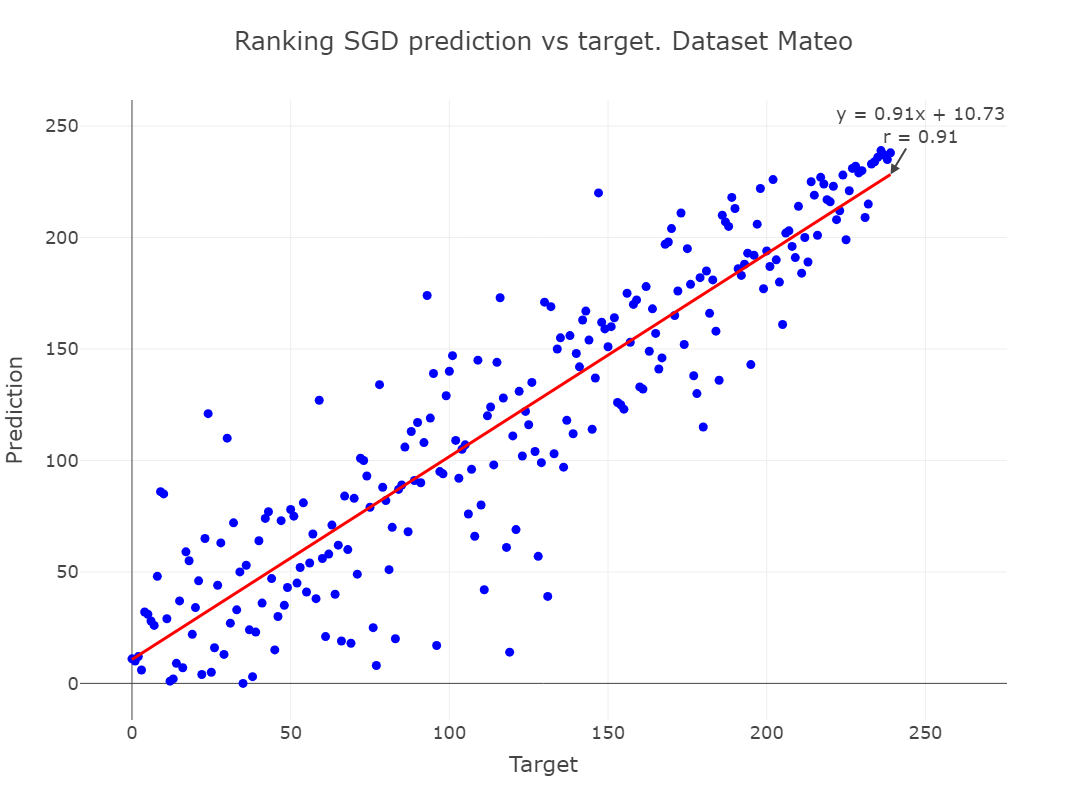

In [37]:
from scipy import stats
import plotly.graph_objs as go
import plotly.express as px
rg_name="SGD"

# Calculate the correlation coefficient
corr_coef = sorted_ranks[rg_name]['target'].corr(sorted_ranks[rg_name]['predict'])

# Fit a linear regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(sorted_ranks[rg_name]['target'], sorted_ranks[rg_name]['predict'])

# Generate points for the fit line
fit_line_x = np.linspace(sorted_ranks[rg_name]['target'].min(), sorted_ranks[rg_name]['target'].max(), 100)
fit_line_y = slope * fit_line_x + intercept

# Create scatter plot of the data points
scatter = go.Scatter(
    x=sorted_ranks[rg_name]['target'], 
    y=sorted_ranks[rg_name]['predict'], 
    mode='markers', 
    name='Data Points',
    marker=dict(color='blue')
)

# Create fit line plot
fit_line = go.Scatter(
    x=fit_line_x, 
    y=fit_line_y, 
    mode='lines', 
    name='Fit Line',
    line=dict(color='red')
)

# Create the layout with the fit line equation and correlation coefficient as annotations
layout = go.Layout(
    title=f"Ranking {rg_name} prediction vs target. Dataset {test_dataset}",
    xaxis=dict(title="Target"),
    yaxis=dict(title="Prediction"),
    annotations=[
        dict(
            x=fit_line_x[-1], 
            y=fit_line_y[-1], 
            xref="x", 
            yref="y", 
            text=f"y = {slope:.2f}x + {intercept:.2f}<br>r = {corr_coef:.2f}",
            showarrow=True,
            arrowhead=2,
            ax=30,
            ay=-50
        )
    ],
    width=1200,  # Adjust the width of the figure
    height=800,
    template="presentation",
    showlegend=False 
)

# Combine the scatter plot and fit line
fig = go.Figure(data=[scatter, fit_line], layout=layout)

fig.write_image(f"regressors/{test_dataset}/ranking_{rg_name}.svg",format="SVG")
fig.write_image(f"regressors/{test_dataset}/ranking_{rg_name}.png",format="PNG")
# Show the plot
fig.show()

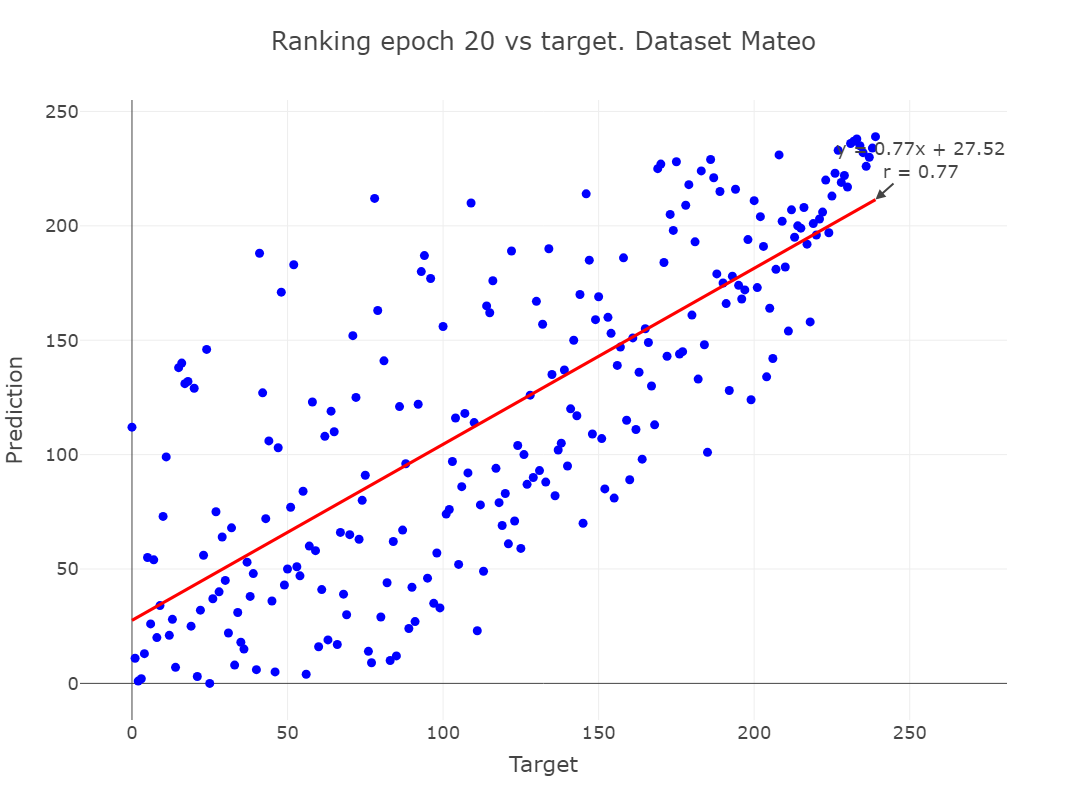

In [41]:
from scipy import stats
import plotly.graph_objs as go
import plotly.express as px
epoch=20

# Calculate the correlation coefficient
corr_coef = sorted_ranks_epochs[epoch]['target'].corr(sorted_ranks_epochs[epoch]['predict'])

# Fit a linear regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(sorted_ranks_epochs[epoch]['target'], sorted_ranks_epochs[epoch]['predict'])

# Generate points for the fit line
fit_line_x = np.linspace(sorted_ranks_epochs[epoch]['target'].min(), sorted_ranks_epochs[epoch]['target'].max(), 100)
fit_line_y = slope * fit_line_x + intercept

# Create scatter plot of the data points
scatter = go.Scatter(
    x=sorted_ranks_epochs[epoch]['target'], 
    y=sorted_ranks_epochs[epoch]['predict'], 
    mode='markers', 
    name='Data Points',
    marker=dict(color='blue')
)

# Create fit line plot
fit_line = go.Scatter(
    x=fit_line_x, 
    y=fit_line_y, 
    mode='lines', 
    name='Fit Line',
    line=dict(color='red')
)

# Create the layout with the fit line equation and correlation coefficient as annotations
layout = go.Layout(
    title=f"Ranking epoch {epoch} vs target. Dataset {test_dataset}",
    xaxis=dict(title="Target"),
    yaxis=dict(title="Prediction"),
    annotations=[
        dict(
            x=fit_line_x[-1], 
            y=fit_line_y[-1], 
            xref="x", 
            yref="y", 
            text=f"y = {slope:.2f}x + {intercept:.2f}<br>r = {corr_coef:.2f}",
            showarrow=True,
            arrowhead=2,
            ax=45,
            ay=-40
        )
    ],
    width=1200,  # Adjust the width of the figure
    height=800,
    template="presentation",
    showlegend=False 
)

# Combine the scatter plot and fit line
fig = go.Figure(data=[scatter, fit_line], layout=layout)

fig.write_image(f"regressors/{test_dataset}/ranking_{epoch}.svg",format="SVG")
fig.write_image(f"regressors/{test_dataset}/ranking_{epoch}.png",format="PNG")
# Show the plot
fig.show()